In [1]:
#@title 1.3. IMPORT LIBRARY

import sys
sys.path.append('../utils')
from data_retrieval import credit_data_retrieval
from neural_net import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [2]:
df = credit_data_retrieval()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Risk
0,0.146949,-0.745131,-1.236478,0.176948,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.146949,0.949817,2.248194,-0.284901,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.383771,-0.416562,-0.738668,0.045495,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.146949,1.634247,1.750384,0.130233,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0.146949,0.566664,0.256953,0.229637,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        probs_class_1 = probs[:, 1]  # Focus on class 1
        targets = targets.double()
        bce_loss = nn.BCELoss(reduction='none')(probs_class_1, targets)
        pt = torch.where(targets == 1, probs_class_1, 1 - probs_class_1)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=0.25, gamma=2)


In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n = df.shape[1] - 1

train_accuracies = []
test_accuracies = []

# Perform 5-fold stratified cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(df, df['Risk'])):
    print(f"Fold {fold+1}/{5}")
    
    # Split the data for this fold
    df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
    X_train, y_train = df_train.drop(columns='Risk'), df_train['Risk']
    X_test, y_test = df_test.drop(columns='Risk'), df_test['Risk']
    
    # Prepare the dataset
    dataset = dict()
    dtype = torch.get_default_dtype()
    dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(y_train.values).type(torch.long).to(device)
    dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype).to(device)
    dataset['test_label'] = torch.from_numpy(y_test.values).type(torch.long).to(device)

    # Initialize model
    model = KAN(width=[n, 6, 2], grid=3, k=2, seed=42, device=device)

    # Train the model and evaluate it
    results = model.fit(dataset, opt="Adam", steps=500, lr=0.001, lamb=0.001, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

    print(f'Fold accuracy: {results['train_acc'][-1], results['test_acc'][-1]}')
    
    train_accuracies.append(results['train_acc'][-1])
    test_accuracies.append(results['test_acc'][-1])

# Output the average accuracies
print(f"Average Train Accuracy: {torch.mean(torch.tensor(train_accuracies)):.4f}")
print(f"Average Test Accuracy: {torch.mean(torch.tensor(test_accuracies)):.4f}")

Fold 1/5
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/500 [00:00<?, ?it/s]

| train_loss: 6.73e-01 | test_loss: 7.08e-01 | reg: 2.35e+01 | : 100%|█| 500/500 [00:17<00:00, 29.33


saving model version 0.1
Fold accuracy: (0.79875, 0.755)
Fold 2/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.50e-01 | test_loss: 7.41e-01 | reg: 2.79e+01 | : 100%|█| 500/500 [00:17<00:00, 29.10


saving model version 0.1
Fold accuracy: (0.81375, 0.78)
Fold 3/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.40e-01 | test_loss: 7.52e-01 | reg: 2.87e+01 | : 100%|█| 500/500 [00:17<00:00, 28.95


saving model version 0.1
Fold accuracy: (0.81875, 0.735)
Fold 4/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.64e-01 | test_loss: 6.99e-01 | reg: 2.40e+01 | : 100%|█| 500/500 [00:17<00:00, 29.19


saving model version 0.1
Fold accuracy: (0.80375, 0.76)
Fold 5/5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.60e-01 | test_loss: 7.24e-01 | reg: 2.54e+01 | : 100%|█| 500/500 [00:17<00:00, 29.13


saving model version 0.1
Fold accuracy: (0.80125, 0.77)
Average Train Accuracy: 0.8073
Average Test Accuracy: 0.7600


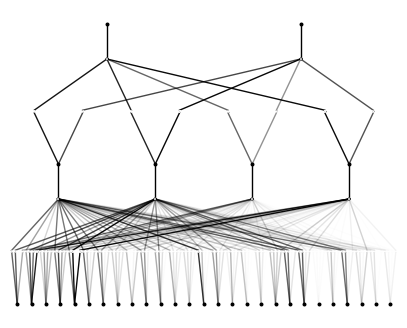

In [7]:
model.plot()

In [35]:
help(model.fit)

Help on method fit in module kan.MultKAN:

fit(dataset, opt='LBFGS', steps=100, log=1, lamb=0.0, lamb_l1=1.0, lamb_entropy=2.0, lamb_coef=0.0, lamb_coefdiff=0.0, update_grid=True, grid_update_num=10, loss_fn=None, lr=1.0, start_grid_update_step=-1, stop_grid_update_step=50, batch=-1, metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', singularity_avoiding=False, y_th=1000.0, reg_metric='edge_forward_spline_n', display_metrics=None) method of kan.MultKAN.MultKAN instance
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            ent